In [30]:
import subprocess
import json
import matplotlib.pyplot as plt
import numpy as np
import csv
import seaborn as sns
from matplotlib import colors

In [3]:
GT_file = "Vertebrata_GT.tsv"
sequence_file = "Vertebrata.fas"
n_epochs = 35
lambda_value = 2.8
n_voters = 5
k = 6
n_clusters = 5
n_mimics = 3
batch_sz = 512
is_num = False

In [4]:
command = f'./iDeLUCS/idelucs/__main__.py --sequence_file={sequence_file} --n_epochs={n_epochs} --n_voters={n_voters} --lambda={lambda_value} --k={k} --n_clusters={n_clusters} --n_mimics={n_mimics} --batch_sz={batch_sz}'

In [5]:
subprocess.run(['bash', '-c', command])


Training Parameters:
sequence_file 	 -> Vertebrata.fas
n_clusters 	 -> 5
n_epochs 	 -> 35
n_mimics 	 -> 3
batch_sz 	 -> 512
GT_file 	 -> None
k 	 -> 6
optimizer 	 -> RMSprop
scheduler 	 -> None
weight 	 -> 0.25
lambda 	 -> 2.8
lr 	 -> 0.001
n_voters 	 -> 5
model_size 	 -> linear
plot 	 -> False
None
No. Sequences: 	 2,500
Min. Length: 	 14,127
Max. Length: 	 24,317
Avg. Length: 	 16,929.48
........... Training Model (5/5)................

/home/jujukoko/.local/lib/python3.10/site-packages/idelucs/utils.py:588: RuntimeWarning: divide by zero encountered in divide
  D = 1.0 / euclidean_distances(features - _sums, cluster.cluster_centers_, squared=True)
/home/jujukoko/.local/lib/python3.10/site-packages/idelucs/utils.py:590: RuntimeWarning: invalid value encountered in divide
  D /= np.sum(D, axis=1)[:, np.newaxis]


........... Computing Results ................{'Davies-Boulding': 1.16665744380794, 'Silhouette-Score': 0.5242352591647227}
........ Saving Results ..............
hihi


CompletedProcess(args=['bash', '-c', './iDeLUCS/idelucs/__main__.py --sequence_file=Vertebrata.fas --n_epochs=35 --n_voters=5 --lambda=2.8 --k=6 --n_clusters=5 --n_mimics=3 --batch_sz=512'], returncode=0)

In [6]:
def read_file(input_file):
    res_list = []
    # Check the file extension
    if input_file.endswith('.csv') or input_file.endswith('.tsv'):
        # Read TSV file and return content as a list
        with open(input_file, 'r') as file:
            reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
            for row in reader:
                res_list.append(row)
    return res_list


In [7]:
def read_GT_file(input_file,is_num):
    # Lire les données du fichier d'entrée
    list_true = read_file(input_file)
    list_true = list_true[1:]
    dico_name = {}
    indice = 0
    for elem in list_true:
        if elem[2] in dico_name:
            elem[2] = dico_name[elem[2]]
        else:
            dico_name[elem[2]]=indice
            elem[2]=indice
            indice+=1
    return list_true

In [33]:
def confusion_matrix(dico_predicted):
    if(GT_file != ""): #only if GT_file exist
        list_true = read_GT_file(GT_file,is_num)
        #create an empty table
        tableau = np.zeros((n_clusters, n_clusters))
        for elem in list_true:
            true_cluster_id = elem[2]  # Remove [2] index
            sequence_id = elem[1]
            predicted_cluster_id = dico_predicted[sequence_id][1]
            tableau[int(true_cluster_id) - 1][int(predicted_cluster_id)] += 1
    return tableau   
        

In [39]:
def print_confusion_matrix(tableau):
    labels = ['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5']

    fig, ax = plt.subplots()
    
    # Création d'une échelle de couleurs personnalisée
    cmap = colors.ListedColormap(['#F2F2F2', '#D3D3D3', '#A9A9D6', '#6B6BA9'])
    
    # Affichage de la matrice de confusion avec imshow()
    im = ax.imshow(tableau, cmap=cmap)
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Affichage des valeurs dans les cellules
    for i in range(len(tableau)):
        for j in range(len(tableau)):
            ax.text(j, i, int(tableau[i, j]), ha="center", va="center", color="black")
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted value")
    ax.set_ylabel("True value")
    
    # Ajout d'une barre de couleur pour l'échelle
    cbar = ax.figure.colorbar(im, ax=ax)
    
    plt.show()

In [14]:
result_dict = {}

# Spécifiez le chemin du fichier de sortie
input_file = './tmp_file'


# Lisez le contenu du fichier JSON
with open(input_file, 'r') as file:
    result_dict = json.load(file)

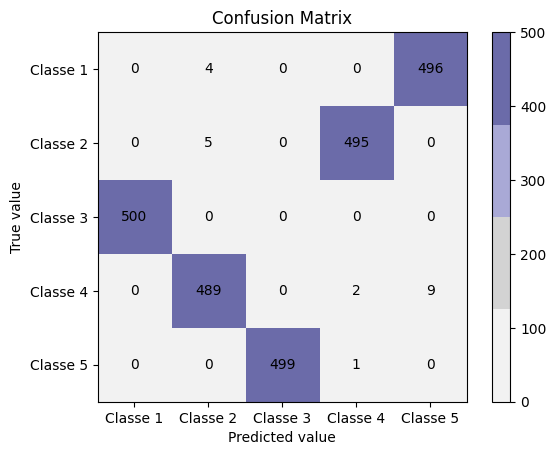

In [40]:
tableau=confusion_matrix(result_dict['assignment'])
print_confusion_matrix(tableau)